In [1]:
import pandas as pd

# Nornalization

In [3]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import torch

def tensor_to_image(t):
    """
    Convert a PyTorch tensor to a NumPy image array suitable for visualization.

    Args:
        t (torch.Tensor or np.ndarray): Image tensor of shape [3, H, W] or [H, W, 3].

    Returns:
        np.ndarray: Image array in [H, W, 3] format with pixel values scaled to [0, 1].
    """
    if isinstance(t, torch.Tensor):
        t = t.detach().cpu().numpy()
        if t.shape[0] == 3:  # Convert from CHW to HWC format
            t = np.transpose(t, (1, 2, 0))
    t = np.clip(t / 255.0, 0, 1)  # Normalize and clip values
    return t

def show_images(images, titles, figsize=(15, 5)):
    """
    Display a list of images with corresponding titles.

    Args:
        images (List[np.ndarray]): List of image arrays (HWC format).
        titles (List[str]): Corresponding titles for each image.
        figsize (tuple): Size of the figure.
    """
    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


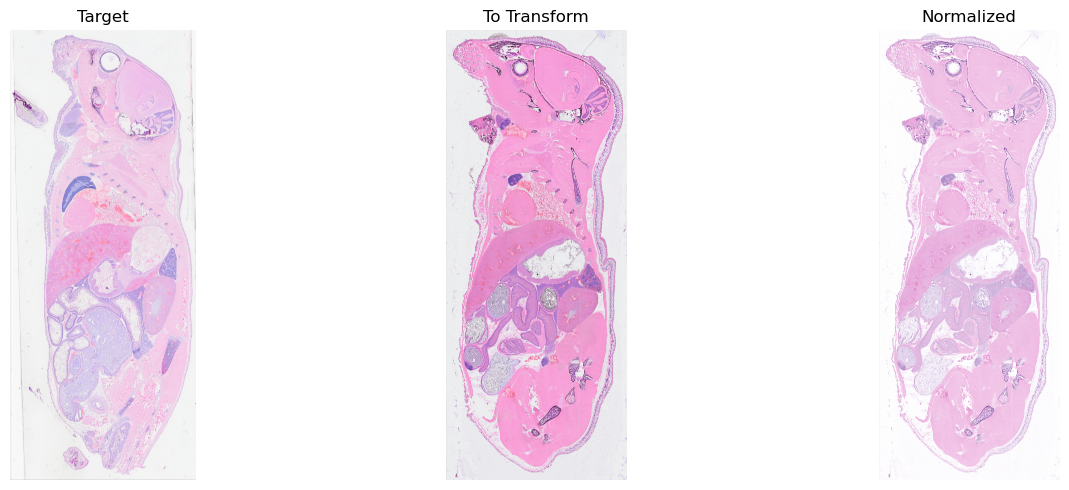

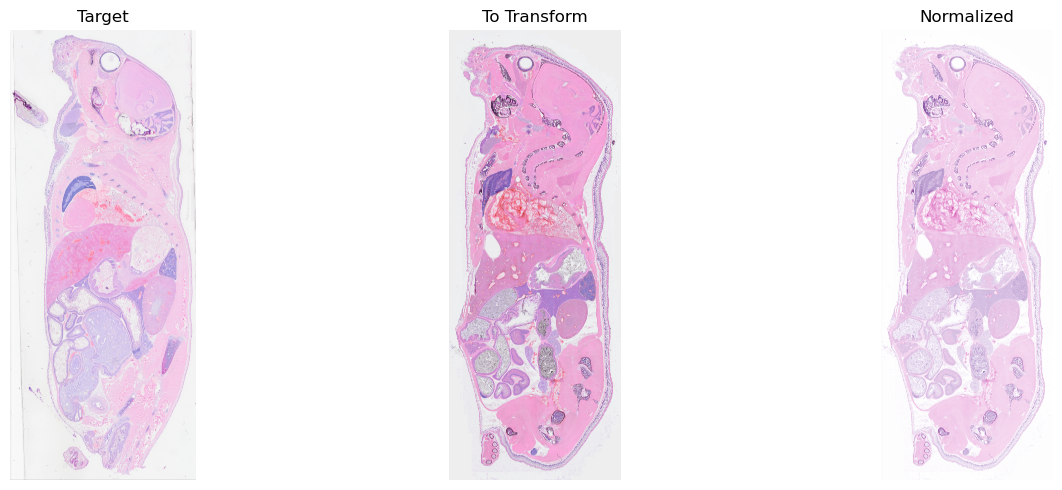

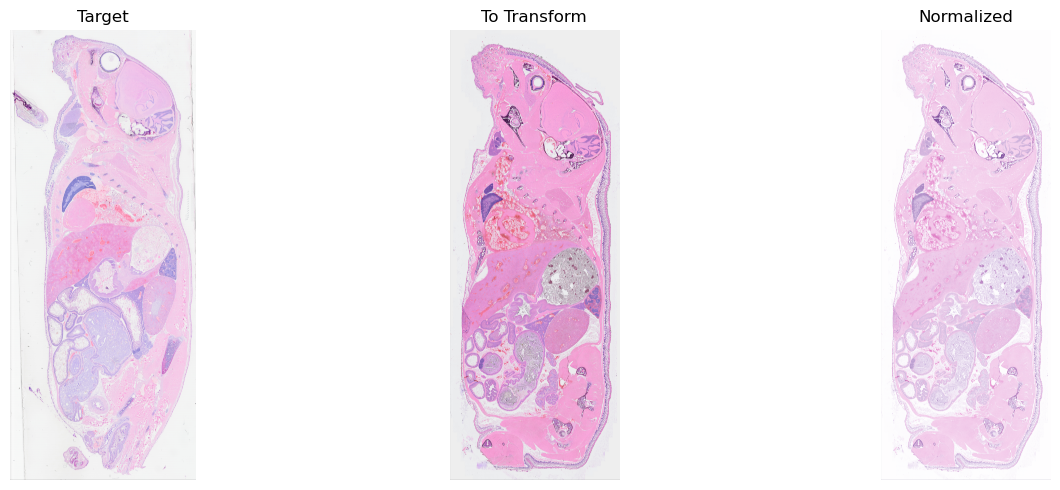

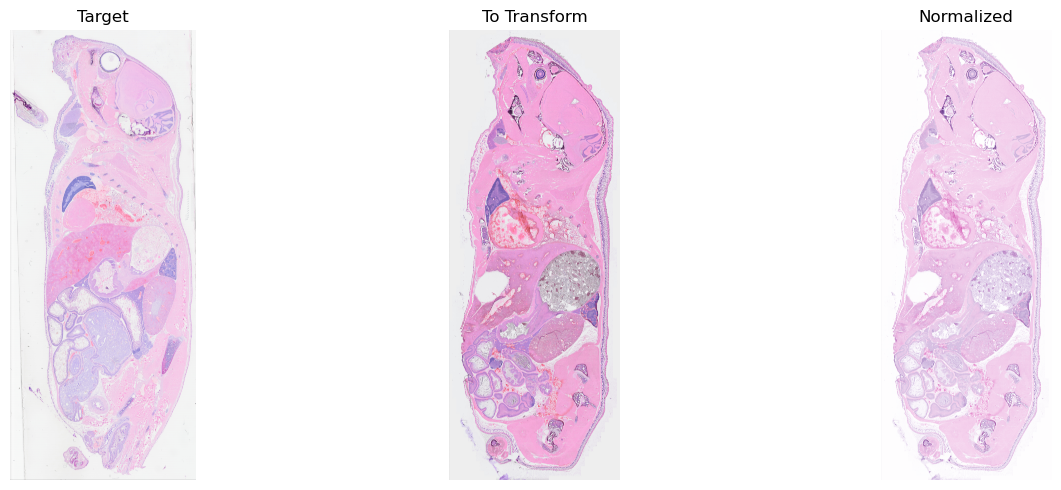

In [18]:
import cv2
import torch
from torchvision.transforms import ToTensor
from torch_staintools.normalizer import NormalizerBuilder
from torch_staintools.augmentor import AugmentorBuilder
import os

# Set random seed for reproducibility
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Choose computation device
device = torch.device("cuda:3")

# Load the target image for stain normalization
# Shape: [H, W, 3] in RGB format
target = cv2.cvtColor(cv2.imread(f"../Images_Downsampled_52X/Image3_DS_52X.png"), cv2.COLOR_BGR2RGB)
target_tensor = ToTensor()(target).unsqueeze(0).to(device)  # Shape: [1, 3, H, W]

# Define batches to normalize
batch_reverse = ['CTRL_1', 'CTRL_2', 'LPS_1', 'LPS_2']

for batch in batch_reverse:
    # Load the image to be normalized
    norm = cv2.cvtColor(cv2.imread(f"../Downsampled_Images/{batch}.png"), cv2.COLOR_BGR2RGB)
    norm_tensor = ToTensor()(norm).unsqueeze(0).to(device)  # Shape: [1, 3, H, W]

    # Build and fit a Vahadane stain normalizer using ISTA for stain concentration
    normalizer_vahadane = NormalizerBuilder.build('vahadane', concentration_method='ista')
    normalizer_vahadane = normalizer_vahadane.to(device)
    normalizer_vahadane.fit(target_tensor)

    # Apply normalization
    output = normalizer_vahadane(norm_tensor).cpu().numpy()

    # Convert output tensor to image format for visualization
    output = np.squeeze(output, axis=0)             # Shape: [3, H, W]
    output = np.moveaxis(output, 0, -1)              # Shape: [H, W, 3]

    # Optional: apply saturation adjustment here if needed
    # output = adjust_saturation_rgb(output, saturation_scale=1.3)

    # Visualize original and normalized images
    show_images(
        [target, norm, output],
        ["Target", "To Transform", "Normalized"]
    )

    # Convert to uint8 and save the normalized image
    output_to_save = (output * 255).clip(0, 255).astype(np.uint8)
    cv2.imwrite(f"../Downsampled_Images/{batch}_norm.png", cv2.cvtColor(output_to_save, cv2.COLOR_RGB2BGR))
